In [1]:
import CodaPCA
import CodaRegressmb as CodaRegress
import numpy as np
from runpca import read_csv
import os
import sklearn
import torch
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
#change module for newer sklearn versions
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection  import KFold
import matplotlib.pyplot as plt
import pandas as pd
import PCARegress

In [2]:
#read in the data. Given an array of which files are regression, classification or unlabelled
data_path = os.getcwd() + "/Aitchinson"

regression_list = [3,4,5,18,21,34,39]
classification_list = [7,8,9,11,12,16,17,19,23,24,25,26,28,29,33,37]
unlabelled_list=[1,2,6,10,13,14,15,20,22,27,30,31,32,35,36,38,40]

r_files = []
c_files = []
u_files = []


for file in os.listdir(data_path):
    for i in regression_list:
        if os.path.isfile(os.path.join(data_path,file)) and 'Data ' + str(i) + '.' in file:
            r_files.append("Aitchinson/" + file)
    for i in classification_list:
        if os.path.isfile(os.path.join(data_path,file)) and 'Data ' + str(i) + '.' in file:
            c_files.append("Aitchinson/" + file)
    for i in unlabelled_list:
        if os.path.isfile(os.path.join(data_path,file)) and 'Data ' + str(i) + '.' in file:
            u_files.append("Aitchinson/" + file)

In [3]:
def coda_val(features, targets, n_components, folds):
    targets = targets.reshape(-1,1)
    param_splits = 2
    kfold_scores = []
    for train, test in folds:        
        Y_train = targets[train]
        X_train = features[train]
        
       
        Y_test = targets[test]
        X_test = features[test]
        
        
        kf_inner = KFold(param_splits)
        
        inner_folds = [i for i in kf_inner.split(X_train)]      
            
        #inner loop for parameter selection (lambda term in combined loss):
        param_grid = [1e-15,1e-12,1e-10,0.01]
        
        max_error = np.inf
        for a in param_grid:
            
            cval_error = []
            #find the parameter which obtains the best inner cross val score
            for train_inner, test_inner in inner_folds:
                
                model = CodaRegress.CoDA_Regress(features.shape[1], n_components, [5,], [3,])
                
                model.fit(torch.FloatTensor(X_train[train_inner]),  torch.FloatTensor(Y_train[train_inner]), a, lr=1e-3,train_size = len(X_train), epochs=1000)

                y_inner_pred = model.predict(torch.FloatTensor(X_train[test_inner]))
    
                cval_error.append(sklearn.metrics.mean_squared_error(Y_train[test_inner],y_inner_pred.detach().numpy()))
        
        
                
    
   
            curr_error = np.mean(cval_error)
            if curr_error < max_error:
                max_error = curr_error
                best_param = a
                print ("Current best", best_param)
        
        
        best_model = CodaRegress.CoDA_Regress(features.shape[1], n_components, [5,], [3,])

        val_arr, train_arr = best_model.fit(torch.FloatTensor(X_train),  torch.FloatTensor(Y_train), best_param, lr=1e-3, train_size = int(len(X_train)*(3/4)), epochs=3000)
        
        print ("Plot!")
        
        plt.plot(val_arr, c="red")
        plt.plot(train_arr, c="blue")
        
        #plt.ylim(top=-min(train_arr))
        plt.ylim(bottom=min(train_arr))

        plt.show()
        
        
        y_pred = best_model.predict(torch.FloatTensor(X_test))
        kfold_scores.append(sklearn.metrics.mean_squared_error(Y_test,y_pred.detach().numpy()))
                
    return kfold_scores

    
    
    

In [4]:

#need to specify where the the targets and features are in the dataset, and whether there are non compositional features

def PCA_Regression(data, co_feature_indices, target_index, 
                   other_feature_indices = [], alg=CodaPCA.Alg.CODAPCA, verbose=True):
    
    #can loop through/optimise this in another way?
    
    headers = data[1]
    
    data = data[0]
    np.random.shuffle(data)
    features = data[:,co_feature_indices]
    targets = data[:,target_index]
    
    #normalise the compositional features. TODO anything extra to deal with non compositional features?
    #features = np.array([feat/sum(feat) for feat in features])

    #can be empty
    #extra_features = data[0][:,other_feature_indices]
    
    #TODO double check this
    #features = np.hstack([features, extra_features])
    
    #compute the CoDA-PCA projection 
    #TODO add component number as a hyperparameter to optimise 
    n_components=2#len(co_feature_indices)-2

    pca = CodaPCA.NonParametricCodaPCA(n_components)#CodaPCA(n_components,lrate=1e-4,nn_shape=[100,100], alg=alg)
    #TODO: check why this is numerically unstable
    #pca = CodaPCA.NonParametricCodaPCA(n_components)

    pca.fit(features)
    
    Y_coda = pca.transform(features)

    pca_clr = CodaPCA.CLRPCA(n_components)
    pca_clr.fit(features)
    
    Y_clr = pca_clr.transform(features)
    
    pca_reg = CodaPCA.PCA(n_components)
    pca_reg.fit(features)
    
    Y_pca = pca_reg.transform(features)
    
    splits = 4
        
    #split data 
    kf = KFold(splits)
        
    folds = [i for i in kf.split(features)]      
    

    lm = Ridge()
    
    coda_score = enhanced_cross_val(lm,Y_coda, targets, folds)
    clr_score = enhanced_cross_val(lm,Y_clr, targets, folds) 
    naive_score = enhanced_cross_val(lm, Y_pca, targets, folds)
    
    regress_score = coda_val(features, targets, n_components, folds)
    


    if verbose:
        print("CoDA-PCA:")
        print(coda_score)
        print("CLR-PCA:")
        print(clr_score)
        print ("Naive regression:")
        print (naive_score)
        print ("CoDA-Regress:")
        print (regress_score)
    

    return coda_score,clr_score,naive_score,regress_score

#training methodology as described in:
#https://papers.nips.cc/paper/3215-learning-with-transformation-invariant-kernels.pdf
def enhanced_cross_val(model, features, targets, folds):
    assert len(features) == len(targets), "Mismatch in length of features and targets"
    
    #define the number of splits and folds uised in the parameter selection
    #stick to smaller splits since we have small datasets
    #splits = 4
    param_splits = 3
    #split data 
    #kf = KFold(splits)
    kfold_scores = []
    
    for train, test in folds:        
        Y_train = targets[train]
        X_train = features[train]
        
       
        Y_test = targets[test]
        X_test = features[test]
        
        #inner loop for parameter selection (regularisation term in Ridge Regression):
        param_grid = [0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0]
        max_score = -np.inf
        for a in param_grid:
            lm = Ridge(a)
   
            curr_score = np.mean(cross_val_score(lm, X_train, Y_train,cv=param_splits))
            if curr_score > max_score:
                max_score = curr_score
                best_param = a
                
        
        #compute test score based on best parameter
        lm = Ridge(best_param)
        lm.fit(X_train, Y_train)
        y_pred = lm.predict(X_test)
        kfold_scores.append(sklearn.metrics.mean_squared_error(Y_test,y_pred))
                
    return kfold_scores




loading Aitchinson/Data 18. Compositions and total pebble counts of 92 glacial tills.csv...
92 samples 5 features
sparsity: 10.434782608695652%


C:\Users\u5801283\Documents\Honours\honours_final\honours\Code\coda-pca-orig\coda\codes\CodaPCA.py:526: RuntimeWarning: invalid value encountered in subtract
  gradU -= gradU.mean( 1, keepdims=True )


Current best 1e-15
Current best 1e-12
Current best 1e-10
epoch 1000, loss 45423.41796875
epoch 2000, loss 43622.89453125
Plot!


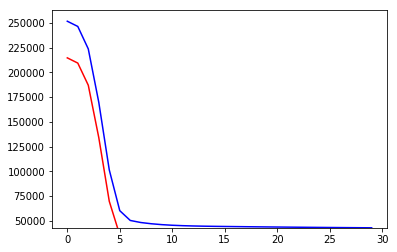

Current best 1e-15
epoch 1000, loss 64241.98828125
epoch 2000, loss 62041.52734375
Plot!


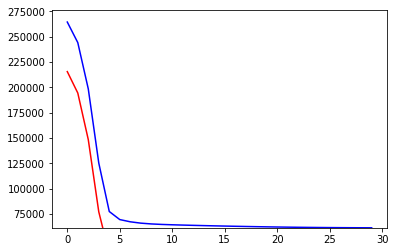

Current best 1e-15
Current best 1e-12
Current best 1e-10
epoch 1000, loss 47816.49609375
epoch 2000, loss 45119.8046875
Plot!


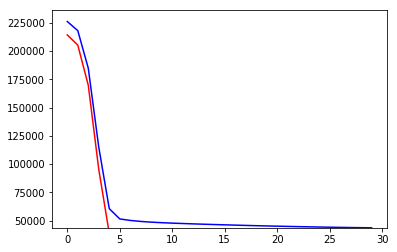

Current best 1e-15
epoch 1000, loss 51247.4609375
epoch 2000, loss 45727.73828125
Plot!


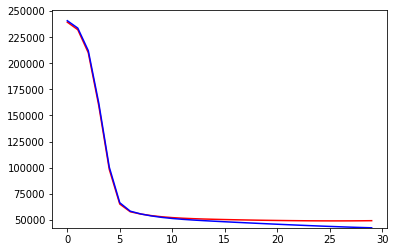

CoDA-PCA:
[72602.36124478931, 26605.289479062933, 73757.74336552162, 42049.514605929755]
CLR-PCA:
[72928.73, 26747.068, 74604.5, 33016.152]
Naive regression:
[68958.31, 23876.475, 67962.58, 65490.6]
CoDA-Regress:
[67290.42, 22374.646, 63960.87, 56532.63]


In [5]:

#can automate this if we had assume a certain structure for the indices of features and targets, or an array per dataset 
%matplotlib inline

score_dict = {} 

#TODO r_files isn't always consistent

# data_21_scores = PCA_Regression(read_csv("Aitchinson/Data 21. Permeabilities of bayesite for 21 mixtures of fibres and bonding pressures..csv", normalize=False), co_feature_indices=[0,1,2,3], target_index=4)
# score_dict['21'] = data_21_scores

# data_21_scores2 = PCA_Regression(read_csv("Aitchinson/Data 21. Permeabilities of bayesite for 21 mixtures of fibres and bonding pressures..csv", normalize=False), co_feature_indices=[0,1,2,3], target_index=5)
# score_dict['21,2'] = data_21_scores2

# data_34_scores = PCA_Regression(read_csv("Aitchinson/Data 34. Foraminiferal compositions at 30 different depths.csv", normalize=False), co_feature_indices=[0,1,2,3], target_index=4) 
# score_dict['34'] = data_34_scores

# data_3_scores = PCA_Regression(read_csv("Aitchinson/Data 3. Compositions and depths of 25 specimens of boxite (Percentages by weight).csv", normalize=False), co_feature_indices=[0,1,2,3,4], target_index=5) 
# score_dict['3'] = data_3_scores

# data_39_scores = PCA_Regression(read_csv("Aitchinson/Data 39. Microhardness of 18 glass specimens and their (Ge, Sb, Se) compositions.csv", normalize=False), co_feature_indices=[0,1,2], target_index=3)
# score_dict['39'] = data_39_scores

# data_4_scores = PCA_Regression(read_csv("Aitchinson/Data 4. Compositions, depths and porosities of 25 specimens of coxite (Percentages by weight).csv", normalize=False), co_feature_indices=[0,1,2,3,4], target_index=5)
# score_dict['4'] = data_4_scores

# data_4_scores2 = PCA_Regression(read_csv("Aitchinson/Data 4. Compositions, depths and porosities of 25 specimens of coxite (Percentages by weight).csv", normalize=False), co_feature_indices=[0,1,2,3,4], target_index=6)
# score_dict['4,2'] = data_4_scores2

# data_5_scores = PCA_Regression(read_csv("Aitchinson/Data 5. Sand, silt, clay compositions of 39 sediment samples at different water depths in an Arctic lake.csv", normalize=False), co_feature_indices=[0,1,2], target_index=3)
# score_dict['5'] = data_5_scores

data_18_scores = PCA_Regression(read_csv("Aitchinson/Data 18. Compositions and total pebble counts of 92 glacial tills.csv", normalize=False), co_feature_indices=[0,1,2,3], target_index=4)
score_dict['18'] = data_18_scores


In [6]:
#note: plotly code works fine, but gives a jupyter warning when saving with a rendered table

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


init_notebook_mode(connected=True)


table_rows = []
for key in score_dict.keys():
    mean_scores = list(map(np.mean, score_dict[key]))
    mean_scores = [ '%.2f' % elem for elem in mean_scores ]
    table_rows.append([key,*mean_scores])
    
results = [go.Table(
    header=dict(values=["","CoDA-PCA", "CLR-PCA", "Naive Regression", "CoDA-Regress"]),
    cells=dict(values=np.array(table_rows).T))]

iplot(results, filename = 'basic_table')    
    
